### Part2: HW_target_customer
__Question #1__. 
Specify a target group of users. Justify your choice using the sample data.

__Question #2__. 
Specify a test and evaluation protocol. How long should the test run? How will you know if you have successfully increased revenue?

__Mathmatical View of the Problem__ 

A *two-for-one* sale, for example, the self-converted customer will spend 2 dollars for 2 gems, however, with promotions, the customer can buy 2 gems with 1 dollar. 
Assuming we have N$_{self convert}$ customers, the rest customers, might be converted by promotion sales N$_{target}$ by conversion rate p. 

- __Without promotion__:
Revenue only comes from self-converted customers. y_np = N$_{self convert}$$\times$2

- __Ideal case with promotion__:
We can perfectly identidy all the self-converted customers, and provide promotion codes to all the other non self-converted customers.
y_ideal = N$_{self convert}$$\times$2 + (N$_{total}$-N$_{self convert}$)$\times$1$\times$p 

- __Real case__:
We select our target customers N$_{target}$ and we might wrongly provide promotion code to self-converted customers (false negative). Assuming self-converted customers will definitely buy the product.
y_real = (N$_{self convert}$-FN)$\times$2 + FN$\times$1 + (N$_{target}$-FN)$\times$1$\times$p. 
The incremental revenue compared with no promotion (N$_{target}$-FN)$\times$1$\times$p-FN.   
Assuming p is a fixed small value, and alpha is the rate FN/N$_{target}$,
__y = [p-alpha$\times$(p+1)]$\times$N$_{target}$__

Therefore the goal is to minimize alpha. 

The main focus of this notebook is to explore the self-converted customer data and feature visualization. 

Plots:
1. Distribution of the first purchase date after app installment. 
2. Revenue vs amount spent. 
3. Retention according to the one-quarter data. 
4. Matthew Effect: a customer who buys once will come back. 


In [1]:
import pandas as pd
import numpy as np
from pylab import *
%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime,date

In [2]:
#self-defined
import hw
from hw import *
#from house_functions import * 

In [3]:
df = pd.read_csv('query_result.csv') # all the columns become object datatype, results from SQL selection  
print('Len of the data',len(df))
df.tail(2)

Len of the data 22576


,udid,install_date,lang,country,hw_ver,os_ver,session_num,session_ts,session_date,iaps_ts,iaps_date,prod_name,prod_type,rev,spend_ts,spend_date,story,spendtype,currency,amount
22574,a4eb133e656a44569895bb75e08c7048,2016-03-07,es,MX,"iPod7,1",9.2,"1,2,3,4","2016-03-07 22:20:51,2016-03-08 19:50:55,2016-0...","2016-03-07,2016-03-08,2016-03-08,2016-03-08",NaN,NaN,NaN,NaN,NaN,2016-03-07 22:23:18,2016-03-07,story_10,earnGemsCounter,gems,-22
22575,50c27649127e456b85d63e8cff304c4b,2016-03-07,en,US,"iPod5,1",9.2.1,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19","2016-03-07 22:27:26,2016-03-08 05:53:45,2016-0...","2016-03-07,2016-03-08,2016-03-08,2016-03-08,20...",NaN,NaN,NaN,NaN,NaN,"2016-03-07 22:37:56,2016-03-07 22:37:56","2016-03-08,2016-03-08","story_10,story_10","earnGemsCounter,earnGemsCounter","gems,gems","-22,-22"


In [4]:
df['install_date']=df['install_date'].astype('datetime64[ns]')

In [5]:
for col in ['session_ts', 'spend_ts', 'iaps_ts', 'rev', 'amount']:
    df[col] = df[col][pd.notnull(df[col])].str.split(",")

In [6]:
df['delta_days_iaps'] = df.apply(lambda x: get_time_delta(x['iaps_ts'],x['install_date']),axis=1)
df['delta_days_sess'] = df.apply(lambda x: get_time_delta(x['session_ts'],x['install_date']),axis=1)
#df['delta_days_spend'] = df.apply(lambda x: get_time_delta(x['spend_ts'],x['install_date']),axis=1)

In [7]:
#rev, amount 
df['rev'] = df['rev'][pd.notnull(df['rev'])].apply(lambda x:list(map(int, x)))
df['amount'] = df['amount'][pd.notnull(df['amount'])].apply(lambda x:list(map(int, x)))

df['rev_sum'] = df['rev'][pd.notnull(df['rev'])].apply(sum)
df['amount_sum'] = df['amount'][pd.notnull(df['amount'])].apply(sum)

### 1. First Purchase Date After Installment 

In [8]:
rev_customer = df[df['rev'].notnull()]

Text(0,0.5,'Counts')

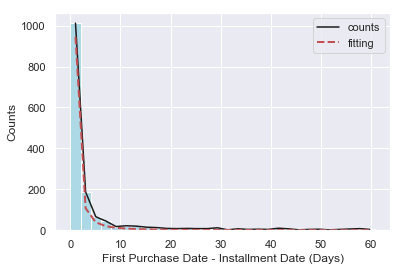

In [9]:
first_purchase_date = rev_customer['delta_days_iaps'][rev_customer['delta_days_iaps'].notnull()].apply(lambda x: x[0])
counts, bins, bars = plt.hist(first_purchase_date,bins=30,color='lightblue')
x = (bins[1:]+bins[:-1])/2.0
plt.plot(x, counts,'k-',label = 'counts')
plt.plot(x,1000/(x)**2,'r--',linewidth =2,label = 'fitting')
plt.legend()
plt.xlabel('First Purchase Date - Installment Date (Days)')
plt.ylabel('Counts')

In [11]:
print('number of self-converted customers with the first day of app installment',
      sum(first_purchase_date<=1)/len(first_purchase_date))

number of self-converted customers with the first day of app installment 0.4744429882044561


As shown by the distribution plot, about 47.4% self-converted customers will pay on the first day of app installment. The number of people who purchase on day P(N) ~ 1/N$^{2}$. On the first day after installment, 1527/22576 (6.76%) is true payers. After the first day, in the left customers (those we still do not know if they are true payers or not), 793/13822 (5.73%) is true payers.  

### 2. Revenue vs Amount Spent 

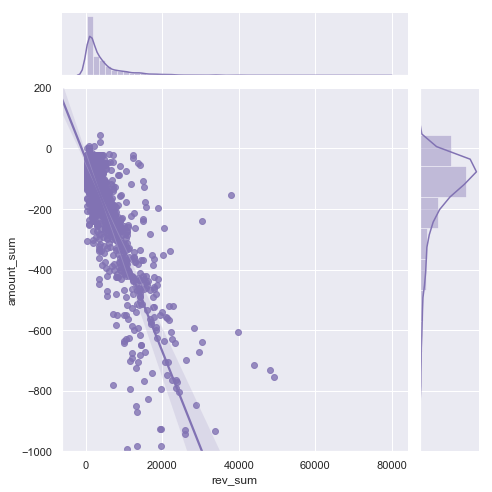

In [12]:
g = sns.jointplot("rev_sum", "amount_sum", data=rev_customer, kind="reg",
                   ylim=(-1000, 200),color="m", height=7)

### 3. Retention (DAU vs time) 

In [13]:
retent=np.zeros(60)
for i in range(0,60):
    retent[i] = (sum(df['delta_days_sess'][pd.notnull(df['delta_days_sess'])].apply(lambda x: retention(x,i))))

Text(0,0.5,'Number of Stayed Customers')

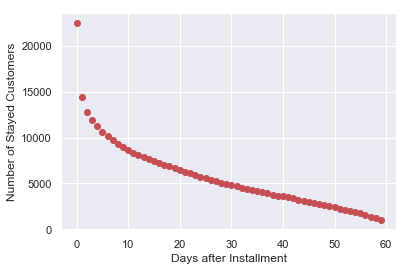

In [14]:
plt.plot(retent,'ro')
plt.xlabel('Days after Installment')
plt.ylabel('Number of Stayed Customers')

### 4. Customers Come Back 

In [15]:
rev_customer['total_iaps'] = rev_customer['iaps_ts'].apply(unique).apply(len)

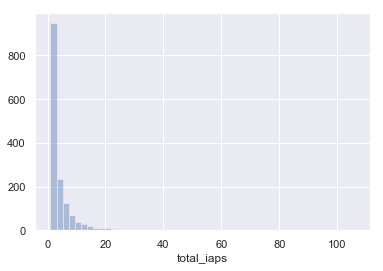

In [16]:
sns.distplot(rev_customer['total_iaps'],kde=False)

In [82]:
sum(rev_customer['total_iaps']>1)/len(rev_customer['total_iaps'])

0.6762778505897772

More than half customers buy more than once. 

In [49]:
print('avg daily app download',mean(df.groupby('install_date').count()['udid']))

avg daily app download 3225.1428571428573


__Question #1__. 
Specify a target group of users. Justify your choice using the sample data.

I tried to think of a way to make the selection without doing the modeling (maybe use some features as cutoff), however, building a model to classify true payer and non payers is still the best way to do I think.  
For each user, I find the time point when the user stops using the game over 24 hrs and use the data before that time point. Then apply the classification model (20 features) to find the "non-payers". The best performed model (random forest) has alpha ~ 0.37%. 

__Question #2__. 
Specify a test and evaluation protocol. How long should the test run? How will you know if you have successfully increased revenue?

__Assumption__: 
The promotion convertion rate is missing and here I adopt the promotion conversion rate 2%, statistical power 80%, and confidence intervel 95%. 

__A/B test__:
Randomly group new users into treatment and control groups. 
The experiment runs for 7 days (eliminate bias from weekend/weekdays, enough time to collect data, enough time for customers to convert). 

__Control group__: No promotion. Conversion rate (2$\times$0.0676 = 0.1352)  
__Treatment group__: Based on the users data before the 24hrs break, apply models to classify non-payer customers and send promotion code to those customers. Lifted conversion rate (2$\times$0.0676-(0.004)$\times$1.02+0.02 = 0.1511) 

[Sample Size](https://docs.adobe.com/content/target-microsite/testcalculator.html) ~8676 per group.  

__Comments__: 
Other metrics worth looking at, the increased total number of payers, gini index of the payers etc.  Long-term effect: some non-payers may transit to be true payers because of the promotion pay. 

Note: Some of my reasoning are based on the analysis in notebook part3.